In [1]:
from anndata import AnnData
import scanpy as sc
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from pygam import GAM, s, te

from sklearn.neighbors import NearestNeighbors


Set parameters

In [2]:
neighbors = 15

colors = {"DCT": "#800515",
               "Endothelium": "#7ae031",
               "UB_CT": "black",
               "Podocyte": "#ad9c00", 
               "Stroma": "#794b82",
               "NPC": "#ff8000", 
               "PT": "#ff00d4", 
               "Int": "#698cff",
               "Ureth": "#d47222", 
               "PEC": "#ff0011", 
               "LOH": "#235e00",
               "Immune Cells": '#757575',
         }

In [3]:
adata = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/model2/FK1_neighborhoodsCalled.h5ad")

In [4]:
adata = adata[adata.obs['NPC_SCVI'] >= 0]

In [5]:
adata

View of AnnData object with n_obs × n_vars = 106284 × 24485
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge', 'AllCounts', '_scvi_batch', '_scvi_labels', 'mean_distance', 'worst_pct', 'cellType_SCANVI', 'leiden_sub18', 'neighbors', 'Endothelium_neighbor', 'UB_CT_neighbor', 'Stroma_neighbor', 'Podocyte_neighbor', 'PT_neighbor', 'PEC_neighbor', 'LOH_neighbor', 'Int_neighbor', 'DCT_neighbor', 'Immune Cells_neighbor', 'Ureth_neighbor', 'DCT_absorbtion_SCVI', 'LOH_absorbtion_SCVI', 'PT_absorbtion_SCVI', 'Podo_absorbtion_SCVI', 'NPC_SCVI', 'Differentiated Cell_SCVI', 'Tubule_SCVI', 'Glomerular_SCVI', 'LatentTime_SCVI', 'PseudoTime_SCVI', 'NephrogenicZone', 'Blastema', 'PES', 'EarlyGlom', 'Podocyte', 'PT', 'PEC', 'LOH', 'DCT

/tmp/ipykernel_139609/457392186.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["dividing"] = (adata.obs["phase"] != "G1")
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)


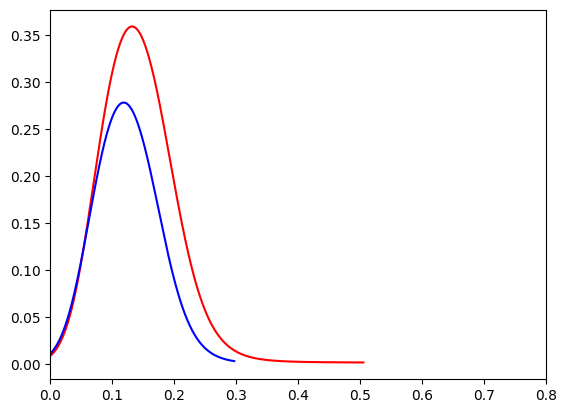

In [6]:
adata.obs["dividing"] = (adata.obs["phase"] != "G1")
adata.obs["dividing"] = adata.obs["dividing"].astype(int)

model = GAM(s(0,spline_order=3,n_splines = 6), distribution='binomial', link = "logit", max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)

x_param = 'PseudoTime_SCVI' 
lineage_1 = "Glomerular_SCVI"
lineage_2 = "Tubule_SCVI"
neighbor = "dividing"
quantile_max = 0.95

###
latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]

X1 = adata_plot_1.obs[[x_param]].to_numpy()
y1 = adata_plot_1.obs[[neighbor]]
w1 = adata_plot_1.obs[lineage_1].to_numpy()

model1 = model
model1.fit(X1,y1,w1)
XX1 = np.linspace(0, latent_max_1, 500)
y_pred1 = model1.predict(XX1)

###
latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

X2 = adata_plot_2.obs[[x_param]].to_numpy()
y2 = adata_plot_2.obs[[neighbor]]
w2 = adata_plot_2.obs[lineage_2].to_numpy()

model2 = model
model2.fit(X2,y2,w2)
XX2 = np.linspace(0, latent_max_2, 500)
y_pred2 = model2.predict(XX2)
###

plt.plot(XX1, y_pred1, color='red', label='Glomerular')
plt.xlim(0, 0.8)
plt.plot(XX2, y_pred2, color='blue', label='Tubular')
plt.show()

In [7]:
def Plot_4_lineages_neighborhoodType(neighborhood_Name, adata):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = 'LOH_absorbtion_SCVI'
    lineage_2 = 'PT_absorbtion_SCVI'
    lineage_3 = 'DCT_absorbtion_SCVI'
    lineage_4 = 'Podo_absorbtion_SCVI'
    quantile_max = 0.95
    
    adata.obs["neighborhood"] = (adata.obs["NeighborHoodsubType"] == neighborhood_Name)
    adata.obs["neighborhood"] = adata.obs["neighborhood"].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborhood"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborhood"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

    ###
    latent_max_3 = adata[adata.obs[lineage_3] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_3 = adata[adata.obs[x_param] < latent_max_3]
    
    X3 = adata_plot_3.obs[[x_param]].to_numpy()
    y3 = adata_plot_3.obs[["neighborhood"]]
    w3 = adata_plot_3.obs[lineage_3].to_numpy()

    model3 = model
    model3.fit(X3,y3,w3)
    XX3 = np.linspace(0, latent_max_3, 500)
    y_pred3 = model3.predict(XX3)

    ###
    latent_max_4 = adata[adata.obs[lineage_4] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_4 = adata[adata.obs[x_param] < latent_max_4]

    X4 = adata_plot_4.obs[[x_param]].to_numpy()
    y4 = adata_plot_4.obs[["neighborhood"]]
    w4 = adata_plot_4.obs[lineage_4].to_numpy()

    model4 = model
    model4.fit(X4,y4,w4)
    XX4 = np.linspace(0, latent_max_4, 500)
    y_pred4 = model4.predict(XX4)
    ###

    plt.plot(XX1, y_pred1, color='red', label='LOH')
    plt.plot(XX2, y_pred2, color='blue', label='PT')
    plt.plot(XX3, y_pred3, color='black', label='DCT')
    plt.plot(XX4, y_pred4, color='darkorange', label='Podocyte')

    plt.xlim(0, 0.8)
    plt.show()

In [8]:
def Plot_2_lineages_neighborhoodType(neighborhood_Name, adata):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = 'Glomerular_SCVI'
    lineage_2 = 'Tubule_SCVI'
    quantile_max = 0.95
    
    adata.obs["neighborhood"] = (adata.obs["NeighborHoodsubType"] == neighborhood_Name)
    adata.obs["neighborhood"] = adata.obs["neighborhood"].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborhood"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborhood"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

   
    ###

    plt.plot(XX1, y_pred1, color='red', label='Glom')
    plt.plot(XX2, y_pred2, color='blue', label='Tubule')

    plt.xlim(0, 0.8)
    plt.show()

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

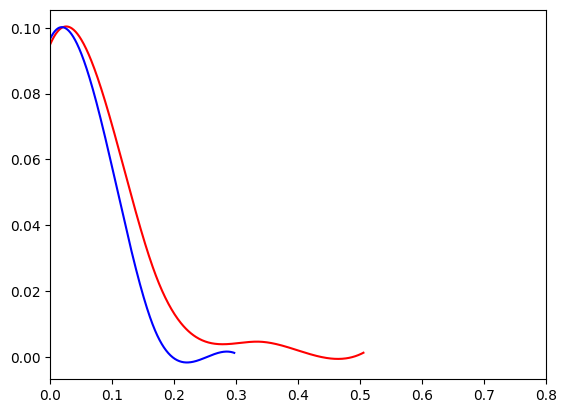

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

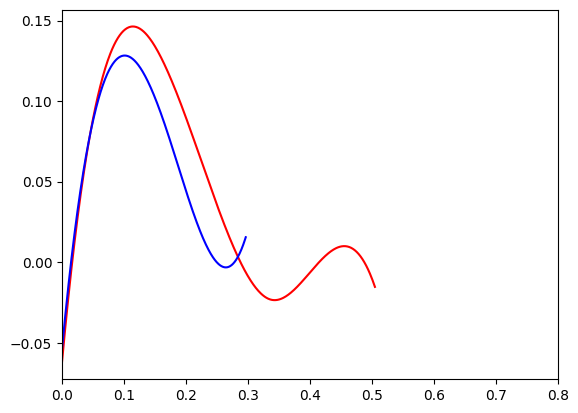

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

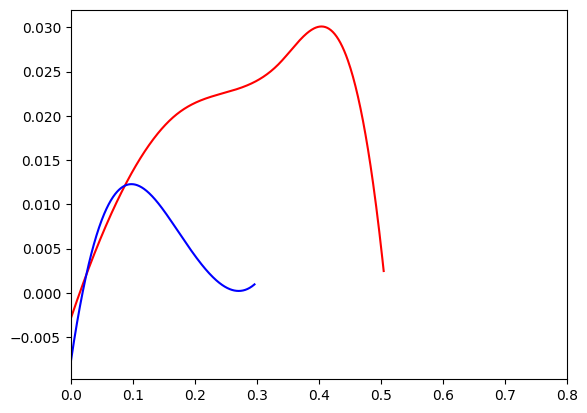

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

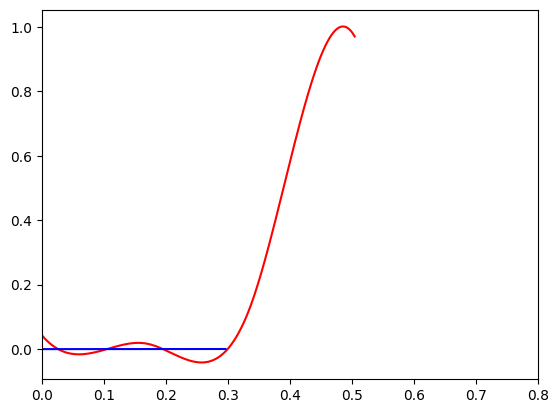

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

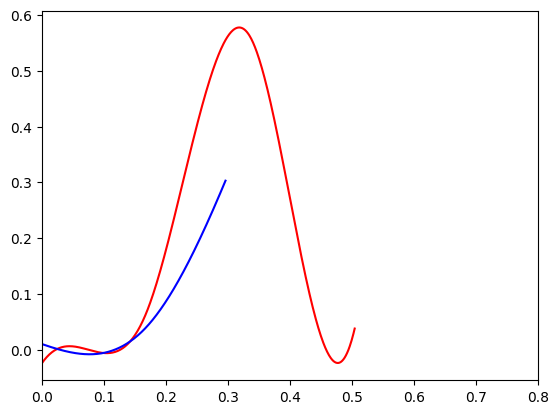

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

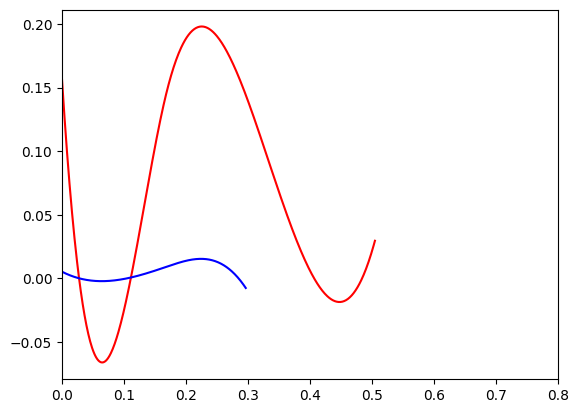

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

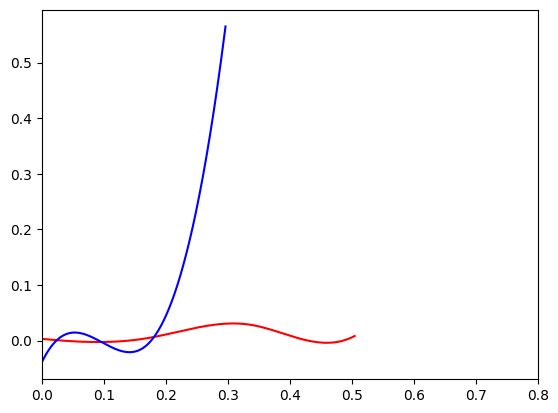

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

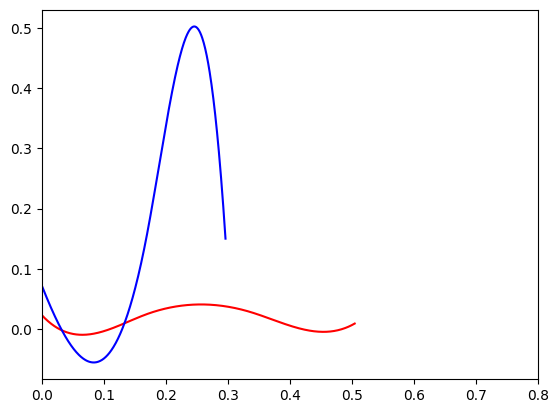

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

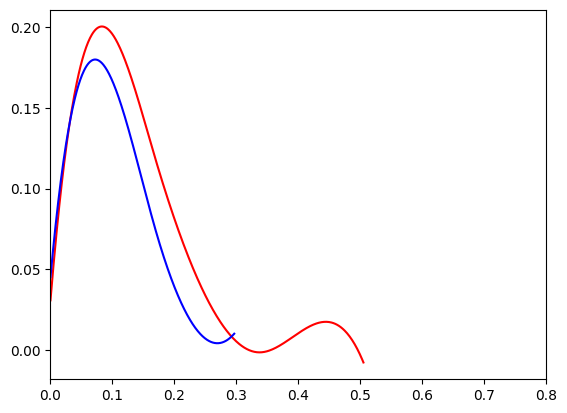

In [9]:
Plot_2_lineages_neighborhoodType("Blastema", adata)
Plot_2_lineages_neighborhoodType("PES", adata)
Plot_2_lineages_neighborhoodType("EarlyGlom", adata)
Plot_2_lineages_neighborhoodType("Podocyte", adata)
Plot_2_lineages_neighborhoodType("PT", adata)
Plot_2_lineages_neighborhoodType("PEC", adata)
Plot_2_lineages_neighborhoodType("LOH", adata)
Plot_2_lineages_neighborhoodType("DCT", adata)
Plot_2_lineages_neighborhoodType("NephrogenicZoneOther", adata)

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

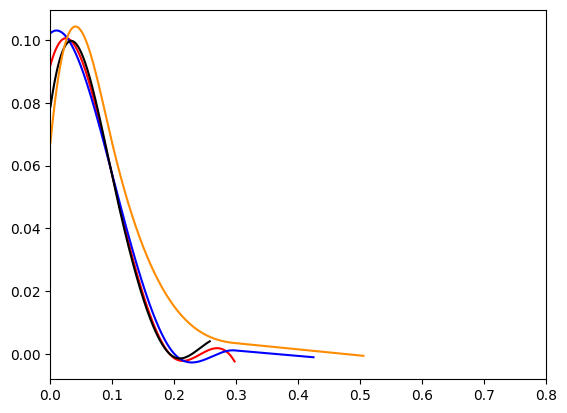

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

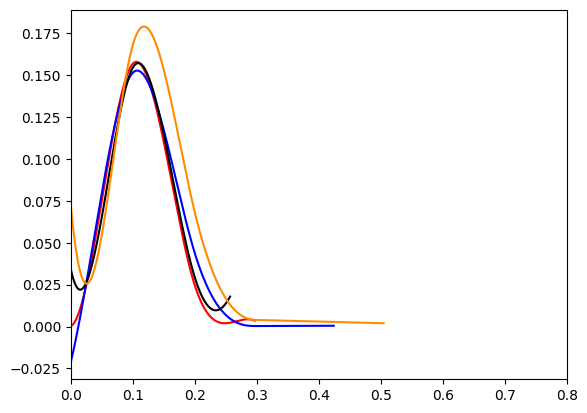

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

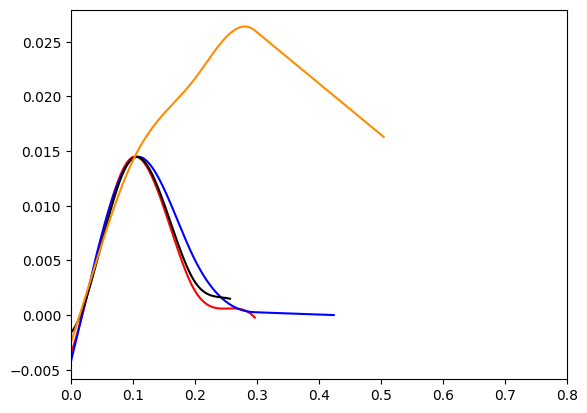

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

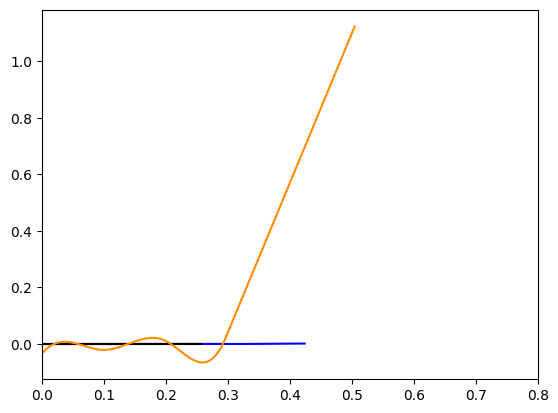

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

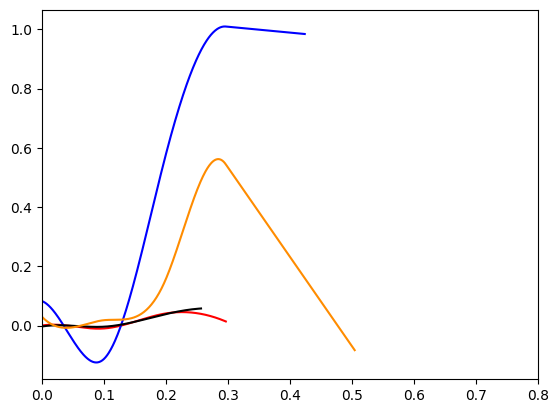

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

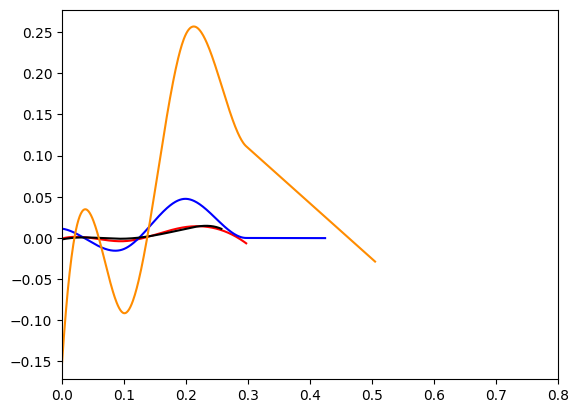

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

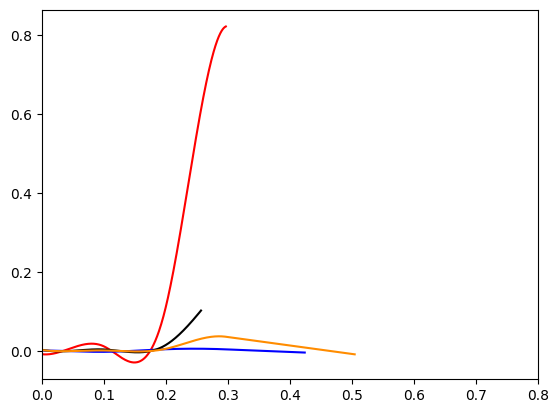

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

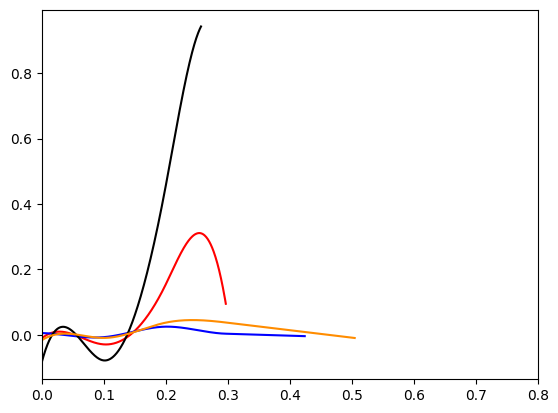

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

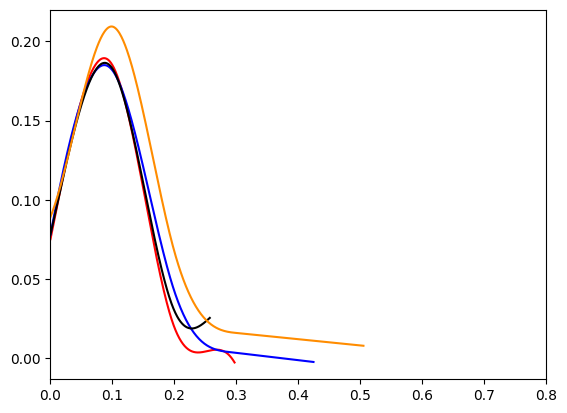

In [10]:
Plot_4_lineages_neighborhoodType("Blastema", adata)
Plot_4_lineages_neighborhoodType("PES", adata)
Plot_4_lineages_neighborhoodType("EarlyGlom", adata)
Plot_4_lineages_neighborhoodType("Podocyte", adata)
Plot_4_lineages_neighborhoodType("PT", adata)
Plot_4_lineages_neighborhoodType("PEC", adata)
Plot_4_lineages_neighborhoodType("LOH", adata)
Plot_4_lineages_neighborhoodType("DCT", adata)
Plot_4_lineages_neighborhoodType("NephrogenicZoneOther", adata)

In [11]:
def Plot_4_lineages_neighborType(neighbor_Name, adata):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = 'LOH_absorbtion_SCVI'
    lineage_2 = 'PT_absorbtion_SCVI'
    lineage_3 = 'DCT_absorbtion_SCVI'
    lineage_4 = 'Podo_absorbtion_SCVI'
    quantile_max = 0.95

    adata.obs["neighborType"] = adata.obs[neighbor_Name].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborType"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborType"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

    ###
    latent_max_3 = adata[adata.obs[lineage_3] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_3 = adata[adata.obs[x_param] < latent_max_3]
    
    X3 = adata_plot_3.obs[[x_param]].to_numpy()
    y3 = adata_plot_3.obs[["neighborType"]]
    w3 = adata_plot_3.obs[lineage_3].to_numpy()

    model3 = model
    model3.fit(X3,y3,w3)
    XX3 = np.linspace(0, latent_max_3, 500)
    y_pred3 = model3.predict(XX3)

    ###
    latent_max_4 = adata[adata.obs[lineage_4] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_4 = adata[adata.obs[x_param] < latent_max_4]

    X4 = adata_plot_4.obs[[x_param]].to_numpy()
    y4 = adata_plot_4.obs[["neighborType"]]
    w4 = adata_plot_4.obs[lineage_4].to_numpy()

    model4 = model
    model4.fit(X4,y4,w4)
    XX4 = np.linspace(0, latent_max_4, 500)
    y_pred4 = model4.predict(XX4)
    ###

    plt.plot(XX1, y_pred1, color='red', label='LOH')
    plt.plot(XX2, y_pred2, color='blue', label='PT')
    plt.plot(XX3, y_pred3, color='black', label='DCT')
    plt.plot(XX4, y_pred4, color='darkorange', label='Podocyte')

    plt.xlim(0, 0.8)
    plt.show()

In [12]:
def Plot_4_lineages_neighborhood(neighbor_name, adata, neighborHood_cluster):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = 'LOH_absorbtion_SCVI'
    lineage_2 = 'PT_absorbtion_SCVI'
    lineage_3 = 'DCT_absorbtion_SCVI'
    lineage_4 = 'Podo_absorbtion_SCVI'
    quantile_max = 0.95

    adata.obs["neighborHood"] = (adata.obs[neighborHood_cluster] == neighbor_name)
    adata.obs["neighborHood"] = adata.obs["neighborHood"].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborHood"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborHood"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

    ###
    latent_max_3 = adata[adata.obs[lineage_3] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_3 = adata[adata.obs[x_param] < latent_max_3]
    
    X3 = adata_plot_3.obs[[x_param]].to_numpy()
    y3 = adata_plot_3.obs[["neighborHood"]]
    w3 = adata_plot_3.obs[lineage_3].to_numpy()

    model3 = model
    model3.fit(X3,y3,w3)
    XX3 = np.linspace(0, latent_max_3, 500)
    y_pred3 = model3.predict(XX3)

    ###
    latent_max_4 = adata[adata.obs[lineage_4] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_4 = adata[adata.obs[x_param] < latent_max_4]

    X4 = adata_plot_4.obs[[x_param]].to_numpy()
    y4 = adata_plot_4.obs[["neighborHood"]]
    w4 = adata_plot_4.obs[lineage_4].to_numpy()

    model4 = model
    model4.fit(X4,y4,w4)
    XX4 = np.linspace(0, latent_max_4, 500)
    y_pred4 = model4.predict(XX4)
    ###

    plt.plot(XX1, y_pred1, color='red', label='LOH')
    plt.plot(XX2, y_pred2, color='blue', label='PT')
    plt.plot(XX3, y_pred3, color='black', label='DCT')
    plt.plot(XX4, y_pred4, color='darkorange', label='Podocyte')

    plt.xlim(0, 0.8)
    plt.show()

In [13]:
def Plot_2_lineages_neighborType(neighbor_Name, adata):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = "Glomerular_SCVI"
    lineage_2 = "Tubule_SCVI"
    quantile_max = 0.95

    adata.obs["neighborType"] = adata.obs[neighbor_Name].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborType"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborType"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

    plt.plot(XX1, y_pred1, color='red', label='Tubule')
    plt.plot(XX2, y_pred2, color='blue', label='Glomerular')

    plt.xlim(0, 0.8)
    plt.show()

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

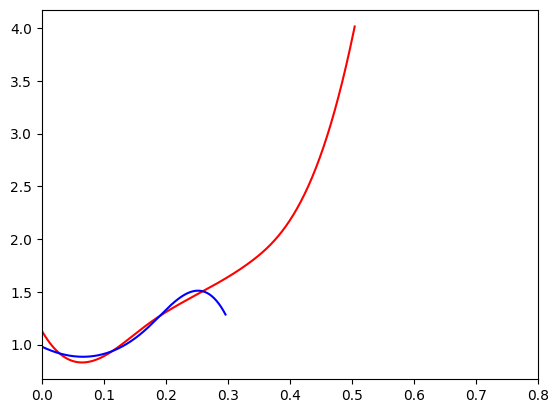

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

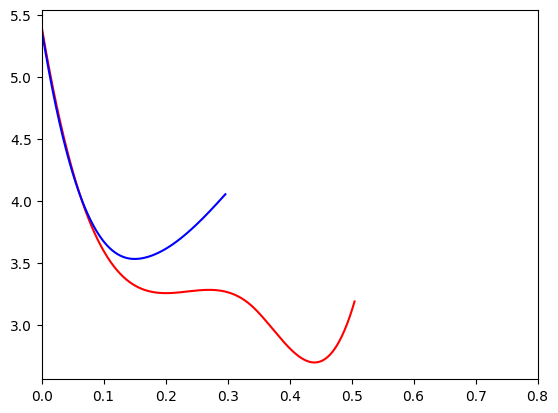

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

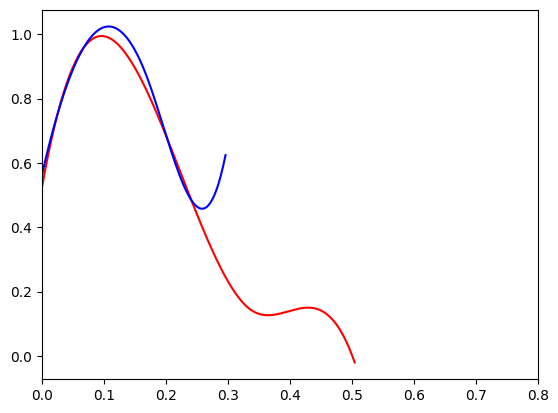

In [14]:
Plot_2_lineages_neighborType("Endothelium_neighbor", adata)
Plot_2_lineages_neighborType("Stroma_neighbor", adata)
Plot_2_lineages_neighborType("UB_CT_neighbor", adata)

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

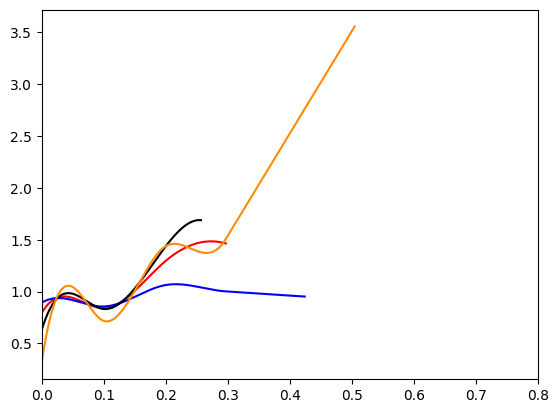

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

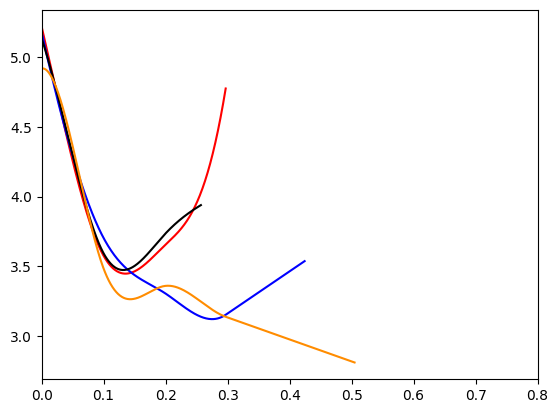

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

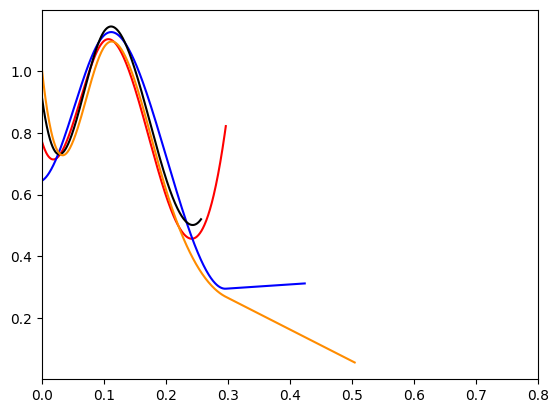

In [15]:
Plot_4_lineages_neighborType("Endothelium_neighbor", adata)
Plot_4_lineages_neighborType("Stroma_neighbor", adata)
Plot_4_lineages_neighborType("UB_CT_neighbor", adata)

## Distance from border

In [16]:
from scipy.stats import gaussian_kde
import seaborn as sns

In [17]:
adata1 = adata[adata.obs["sample"] == "1"]

/tmp/ipykernel_139609/344731771.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['dist_to_border'], hist = False, kde = True,
/tmp/ipykernel_139609/344731771.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['dist_to_border'], hist = False, kde = True,
/tmp/i

Text(0, 0.5, 'Density')

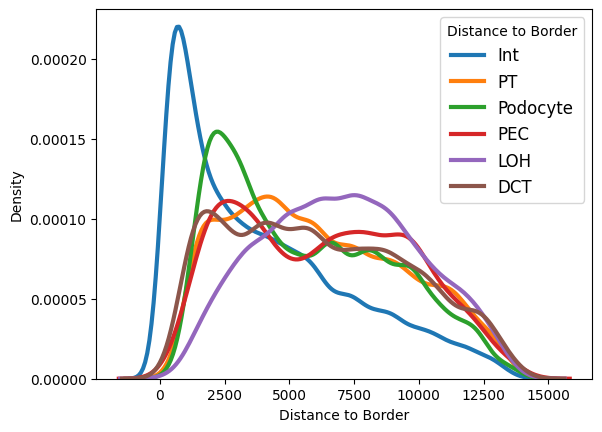

In [18]:
cellTypes = ['Int', 'PT', 'Podocyte','PEC','LOH', 'DCT']

# Iterate through the five airlines
for cellType in cellTypes:
    # Subset to the airline
    subset = adata1.obs[adata1.obs['cellType_SCANVI'] == cellType]
    
    # Draw the density plot
    sns.distplot(subset['dist_to_border'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = cellType)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Distance to Border')
plt.xlabel('Distance to Border')
plt.ylabel('Density')

/tmp/ipykernel_139609/1441252102.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['dist_to_NephrogenicZone'], hist = False, kde = True,
/tmp/ipykernel_139609/1441252102.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['dist_to_NephrogenicZone'], hist = False

Text(0, 0.5, 'Density')

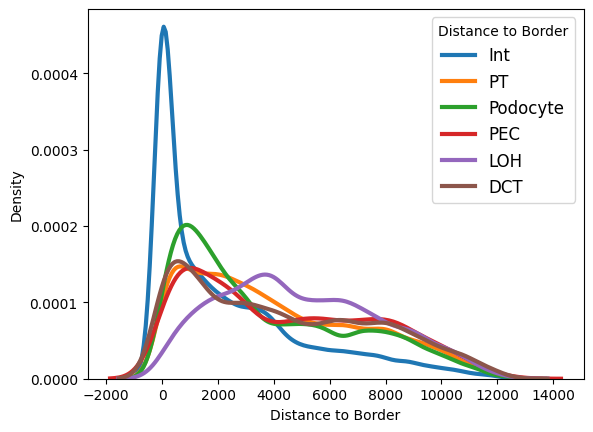

In [19]:
cellTypes = ['Int', 'PT', 'Podocyte','PEC','LOH', 'DCT']

# Iterate through the five airlines
for cellType in cellTypes:
    # Subset to the airline
    subset = adata1.obs[adata1.obs['cellType_SCANVI'] == cellType]
    
    # Draw the density plot
    sns.distplot(subset['dist_to_NephrogenicZone'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = cellType)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Distance to Border')
plt.xlabel('Distance to Border')
plt.ylabel('Density')